# Time Series Forecasting with TensorFlow

### Contents of this notebook
  * Get the time series data
    * Load the time series data using Pandas/Python,s CSV module
  * Format data for a time series problem
    * Creating training and test sets (the wrong way)
    * Creating training and test sets (the right way)
    * Visualizing time series data
    * Turning time series data into a supervised learning problem (windowing)
    * Preparing univariate and multivariate
  * Evaluating a time series forecasting model
  * Setting up a series of deep learning modelling experiments
    * Dense (fully-connected) networks
    * Sequence models (LSTM and 1D CNN)
    * Ensembling (combining multiple models together)
    * Multivariate models
    * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
  * Creating a model checkpoint to save the best performing model during training
  * Making predictions (forecasts) with a time series model
  * Creating prediction intervals for the time series model forecasts
  * Discussing two different types of uncertainity in machine learning (data uncertainity and model uncertainity)
  * Demonstrating why forecasting in an open system is BS (the turkey problem)

### Check for GPU

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d389594e-7050-a342-7db9-6a5f957a8321)


## Get data

In [2]:
# Download Bitcoin historical data from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-03-05 16:25:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-03-05 16:25:18 (7.12 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas

In [3]:
# Import with pandas
import pandas as pd
import numpy as np
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

In [4]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
df.shape

(2787, 5)

In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


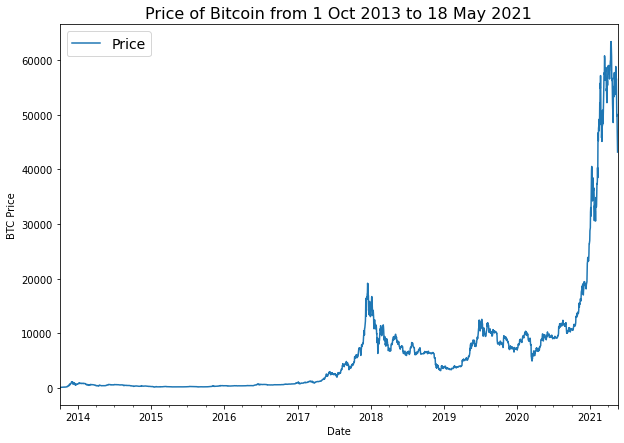

In [8]:
# Visulaizing data
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

In [9]:
# Importing and formatting historical Bitcoin data with Python

import csv
from datetime import datetime

timesteps = []
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as f:
  csv_reader = csv.reader(f, delimiter=',')
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# View first 10 of each

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

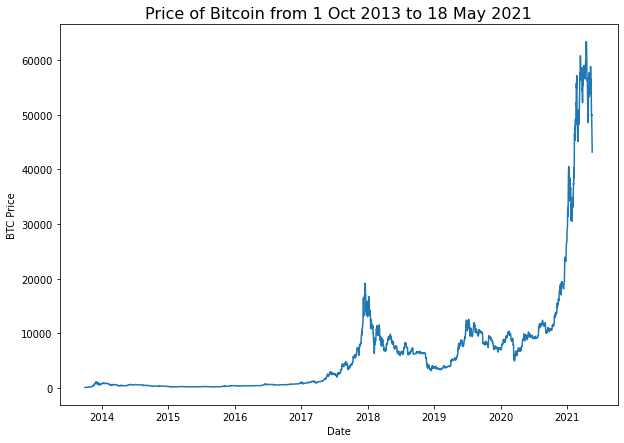

In [10]:
# Plot from CSV
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.xlabel('Date')

## Formatting data for time series problem

### Creating train and test sets for time series data (the wrong way)

In [11]:
# Get Bitcoin date array

timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

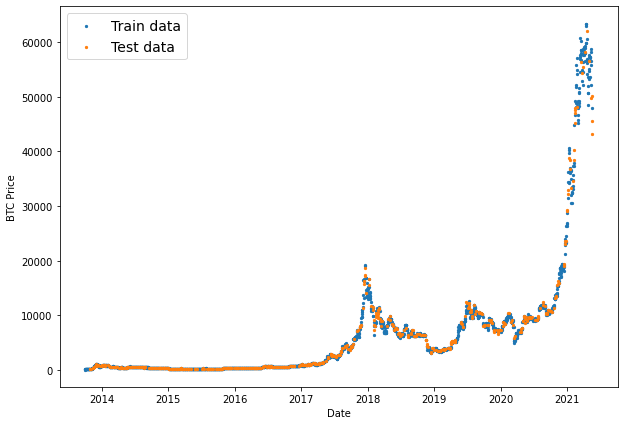

In [13]:
# Plotting wrong train and test splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating train and test sets for time series data (the right way)

In [14]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[0:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

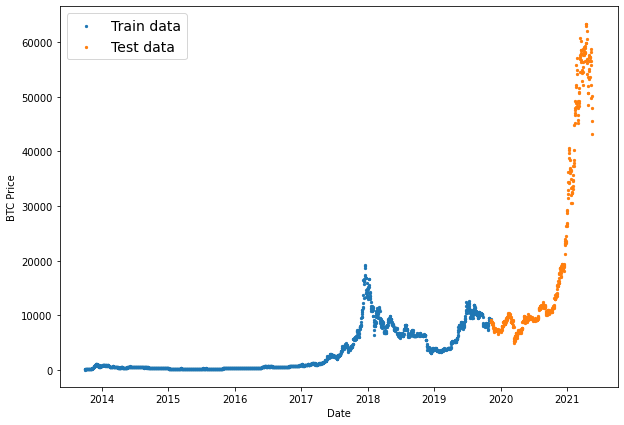

In [15]:
# Plot correctly made splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating a plotting function

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True) 

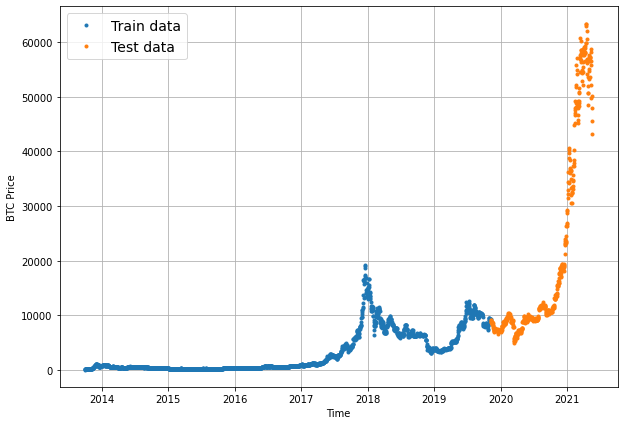

In [17]:
# Try out our plotting function

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

## Modelling Experiments

### Model 0: Naive Forecast (baseline)

In [18]:
# Create a naive forecast

naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

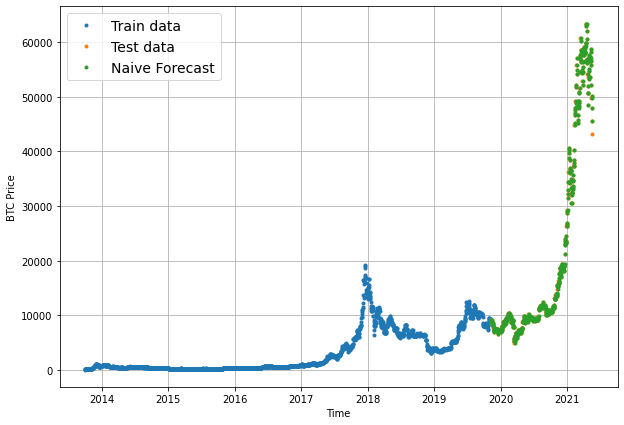

In [19]:
# Plot naive forecast

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, label='Naive Forecast')

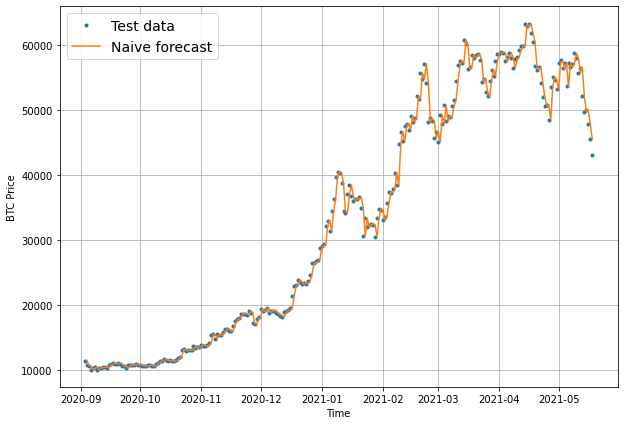

In [20]:
# Zooming in the plot

plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format='-', label='Naive forecast')


### Evaluating a time series model

In [21]:
import tensorflow as tf

In [22]:
# Create a function to calculate MASE (mean absolute scaled error)

def mean_absolute_scaled_error(y_true, y_pred):
  
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  
  return mae/mae_naive_no_season

In [23]:
# Create a function to calculate results (predictions)

def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Other models/libraries for time series forecasting
  * Moving average
  * ARIMA (AutoRegression Integrated Moving Average)
  * Sktime (Scikit-learn for time series)
  * TensorFlow Decision Forecasts (random forest, gradient boosting trees)
  * Facebook Kats (purpose built forecasting and time series analysis library by facebook)
  * LinkedIn Greykite (flexible, intuitive and fast forecasts)


### Windowing dataset

In [25]:
HORIZON = 1           # Predict 1 step at a time
WINDOW_SIZE = 7       # Use a week worth of timestamps to predict the horizon

In [26]:
# Create a function to label windowed data

def get_labelled_windows(x, horizon=1):

  return x[:,:-horizon], x[:,-horizon:]

In [27]:
# Test out the window labelling function

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {test_window} -> Label: {test_label}")

Window: [[1 2 3 4 5 6 7]] -> Label: [[8]]


In [28]:
# Create a function to view NumPy arrays as windows

def make_windows(x, window_size=7, horizon=1):

  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for zero indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [30]:
# View the first three windows/labels

for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


### Turning windows into training and test sets

In [31]:
# Make the train test split

def make_train_test_split(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [33]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Make modelling checkpoint

In [34]:
import os

# Create a function ti implement model checkpoint callback with a specific filename

def create_model_checkpoint(model_name, save_path="model_experiments"):
  
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

### Model 1: Dense model (window = 7, horizon = 1)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# Set seed
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 3238.1382 - mae: 3238.1382  

18/18 [==============================] - 6s 68ms/step - loss: 2568.8435 - mae: 2568.8435 - val_loss: 2741.1619 - val_mae: 2741.1619
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 402.0458 - mae: 402.0458

18/18 [==============================] - 1s 41ms/step - loss: 383.8526 - mae: 383.8526 - val_loss: 1823.9698 - val_mae: 1823.9698
Epoch 3/100
14/18 [======================>.......] - ETA: 0s - loss: 249.4046 - mae: 249.4046

18/18 [==============================] - 1s 41ms/step - loss: 242.4872 - mae: 242.4872 - val_loss: 1204.7505 - val_mae: 1204.7505
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 195.5072 - mae: 195.5072

18/18 [==============================] - 1s 41ms/step - loss: 193.4988 - mae: 193.4988 - val_loss: 1055.1154 - val_mae: 1055.1154
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 182.2473 - mae: 182.2473

18/18 [==============================] - 1s 61ms/step - loss: 182.2473 - mae: 182.2473 - val_loss: 1024.3694 - val_mae: 1024.3694
Epoch 6/100
11/18 [=================>............] - ETA: 0s - loss: 177.0926 - mae: 177.0926

18/18 [==============================] - 1s 63ms/step - loss: 179.3844 - mae: 179.3844 - val_loss: 1004.9159 - val_mae: 1004.9159
Epoch 7/100
11/18 [=================>............] - ETA: 0s - loss: 185.2498 - mae: 185.2498

18/18 [==============================] - 1s 60ms/step - loss: 173.0999 - mae: 173.0999 - val_loss: 990.3141 - val_mae: 990.3141
Epoch 8/100
14/18 [======================>.......] - ETA: 0s - loss: 167.0009 - mae: 167.0009

18/18 [==============================] - 1s 43ms/step - loss: 171.2810 - mae: 171.2810 - val_loss: 945.2846 - val_mae: 945.2846
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 168.6029 - mae: 168.6029 - val_loss: 979.6608 - val_mae: 979.6608
Epoch 10/100
14/18 [======================>.......] - ETA: 0s - loss: 161.6986 - mae: 161.6986

18/18 [==============================] - 1s 43ms/step - loss: 165.0353 - mae: 165.0353 - val_loss: 913.2583 - val_mae: 913.2582
Epoch 11/100
13/18 [====================>.........] - ETA: 0s - loss: 167.0152 - mae: 167.0152

18/18 [==============================] - 1s 40ms/step - loss: 161.4984 - mae: 161.4984 - val_loss: 896.2764 - val_mae: 896.2764
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 158.1207 - mae: 158.1207 - val_loss: 930.5270 - val_mae: 930.5270
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 157.8987 - mae: 157.8987 - val_loss: 927.9916 - val_mae: 927.9916
Epoch 14/100
15/18 [========================>.....] - ETA: 0s - loss: 154.0233 - mae: 154.0233

18/18 [==============================] - 1s 41ms/step - loss: 156.4729 - mae: 156.4729 - val_loss: 887.9328 - val_mae: 887.9328
Epoch 15/100
18/18 [==============================] - ETA: 0s - loss: 152.0842 - mae: 152.0842

18/18 [==============================] - 1s 42ms/step - loss: 152.0842 - mae: 152.0842 - val_loss: 835.3795 - val_mae: 835.3795
Epoch 16/100
15/18 [========================>.....] - ETA: 0s - loss: 147.8245 - mae: 147.8245

18/18 [==============================] - 1s 42ms/step - loss: 148.1896 - mae: 148.1896 - val_loss: 822.3954 - val_mae: 822.3954
Epoch 17/100
15/18 [========================>.....] - ETA: 0s - loss: 144.2646 - mae: 144.2646

18/18 [==============================] - 1s 41ms/step - loss: 147.2082 - mae: 147.2082 - val_loss: 812.8082 - val_mae: 812.8082
Epoch 18/100
17/18 [===========================>..] - ETA: 0s - loss: 145.6269 - mae: 145.6269

18/18 [==============================] - 1s 41ms/step - loss: 144.7083 - mae: 144.7083 - val_loss: 808.8531 - val_mae: 808.8531
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 140.9391 - mae: 140.9391 - val_loss: 819.4109 - val_mae: 819.4109
Epoch 20/100
16/18 [=========================>....] - ETA: 0s - loss: 139.6014 - mae: 139.6014

18/18 [==============================] - 1s 42ms/step - loss: 140.6112 - mae: 140.6112 - val_loss: 770.9993 - val_mae: 770.9993
Epoch 21/100
18/18 [==============================] - ETA: 0s - loss: 141.1020 - mae: 141.1020

18/18 [==============================] - 1s 41ms/step - loss: 141.1020 - mae: 141.1020 - val_loss: 761.8860 - val_mae: 761.8860
Epoch 22/100
18/18 [==============================] - 0s 6ms/step - loss: 136.0926 - mae: 136.0926 - val_loss: 771.7581 - val_mae: 771.7581
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 139.1677 - mae: 139.1677 - val_loss: 815.5013 - val_mae: 815.5013
Epoch 24/100
14/18 [======================>.......] - ETA: 0s - loss: 135.9375 - mae: 135.9375

18/18 [==============================] - 1s 42ms/step - loss: 134.2082 - mae: 134.2082 - val_loss: 734.5693 - val_mae: 734.5693
Epoch 25/100
15/18 [========================>.....] - ETA: 0s - loss: 137.3474 - mae: 137.3474

18/18 [==============================] - 1s 39ms/step - loss: 131.8497 - mae: 131.8497 - val_loss: 730.9067 - val_mae: 730.9067
Epoch 26/100
18/18 [==============================] - 0s 7ms/step - loss: 137.4801 - mae: 137.4801 - val_loss: 802.3792 - val_mae: 802.3792
Epoch 27/100
12/18 [===================>..........] - ETA: 0s - loss: 140.4956 - mae: 140.4956

18/18 [==============================] - 1s 54ms/step - loss: 134.2087 - mae: 134.2087 - val_loss: 725.0704 - val_mae: 725.0704
Epoch 28/100
11/18 [=================>............] - ETA: 0s - loss: 132.2157 - mae: 132.2157

18/18 [==============================] - 1s 65ms/step - loss: 128.5307 - mae: 128.5307 - val_loss: 700.3869 - val_mae: 700.3869
Epoch 29/100
18/18 [==============================] - 0s 10ms/step - loss: 127.2603 - mae: 127.2603 - val_loss: 717.0878 - val_mae: 717.0878
Epoch 30/100
18/18 [==============================] - 0s 9ms/step - loss: 130.6004 - mae: 130.6004 - val_loss: 732.7326 - val_mae: 732.7326
Epoch 31/100
18/18 [==============================] - 0s 10ms/step - loss: 130.6560 - mae: 130.6560 - val_loss: 739.2324 - val_mae: 739.2324
Epoch 32/100
12/18 [===================>..........] - ETA: 0s - loss: 128.6812 - mae: 128.6812

18/18 [==============================] - 1s 63ms/step - loss: 126.6156 - mae: 126.6156 - val_loss: 676.2332 - val_mae: 676.2332
Epoch 33/100
18/18 [==============================] - ETA: 0s - loss: 123.3093 - mae: 123.3093

18/18 [==============================] - 1s 40ms/step - loss: 123.3093 - mae: 123.3093 - val_loss: 665.3995 - val_mae: 665.3995
Epoch 34/100
17/18 [===========================>..] - ETA: 0s - loss: 119.9099 - mae: 119.9099

18/18 [==============================] - 1s 40ms/step - loss: 120.6158 - mae: 120.6158 - val_loss: 653.7702 - val_mae: 653.7702
Epoch 35/100
16/18 [=========================>....] - ETA: 0s - loss: 119.1339 - mae: 119.1339

18/18 [==============================] - 1s 41ms/step - loss: 119.2639 - mae: 119.2639 - val_loss: 646.6472 - val_mae: 646.6472
Epoch 36/100
18/18 [==============================] - 0s 6ms/step - loss: 121.5696 - mae: 121.5696 - val_loss: 648.6033 - val_mae: 648.6033
Epoch 37/100
13/18 [====================>.........] - ETA: 0s - loss: 119.8321 - mae: 119.8321

18/18 [==============================] - 1s 43ms/step - loss: 118.8443 - mae: 118.8443 - val_loss: 640.5706 - val_mae: 640.5706
Epoch 38/100
18/18 [==============================] - ETA: 0s - loss: 118.4690 - mae: 118.4690

18/18 [==============================] - 1s 41ms/step - loss: 118.4690 - mae: 118.4690 - val_loss: 632.7928 - val_mae: 632.7928
Epoch 39/100
12/18 [===================>..........] - ETA: 0s - loss: 119.0290 - mae: 119.0290

18/18 [==============================] - 1s 42ms/step - loss: 116.0729 - mae: 116.0729 - val_loss: 625.6600 - val_mae: 625.6600
Epoch 40/100
17/18 [===========================>..] - ETA: 0s - loss: 115.2215 - mae: 115.2215

18/18 [==============================] - 1s 41ms/step - loss: 114.9718 - mae: 114.9718 - val_loss: 620.0323 - val_mae: 620.0323
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 117.0564 - mae: 117.0564 - val_loss: 679.2752 - val_mae: 679.2752
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 119.5849 - mae: 119.5849 - val_loss: 654.7101 - val_mae: 654.7101
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 116.4570 - mae: 116.4570 - val_loss: 626.4213 - val_mae: 626.4213
Epoch 44/100
18/18 [==============================] - 0s 7ms/step - loss: 115.8346 - mae: 115.8346 - val_loss: 641.4310 - val_mae: 641.4310
Epoch 45/100
16/18 [=========================>....] - ETA: 0s - loss: 116.5495 - mae: 116.5495

18/18 [==============================] - 1s 42ms/step - loss: 117.3388 - mae: 117.3388 - val_loss: 617.7045 - val_mae: 617.7045
Epoch 46/100
18/18 [==============================] - 0s 6ms/step - loss: 113.4706 - mae: 113.4706 - val_loss: 657.3715 - val_mae: 657.3715
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 119.9518 - mae: 119.9518 - val_loss: 765.3763 - val_mae: 765.3763
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 113.8117 - mae: 113.8117 - val_loss: 619.5366 - val_mae: 619.5366
Epoch 49/100
18/18 [==============================] - 0s 8ms/step - loss: 112.3794 - mae: 112.3794 - val_loss: 627.1153 - val_mae: 627.1153
Epoch 50/100
15/18 [========================>.....] - ETA: 0s - loss: 114.9120 - mae: 114.9120

18/18 [==============================] - 1s 43ms/step - loss: 116.7356 - mae: 116.7356 - val_loss: 592.3962 - val_mae: 592.3962
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 112.4107 - mae: 112.4107 - val_loss: 619.8136 - val_mae: 619.8136
Epoch 52/100
18/18 [==============================] - 0s 7ms/step - loss: 119.9270 - mae: 119.9270 - val_loss: 617.4674 - val_mae: 617.4674
Epoch 53/100
18/18 [==============================] - 0s 6ms/step - loss: 118.3926 - mae: 118.3926 - val_loss: 605.5128 - val_mae: 605.5128
Epoch 54/100
18/18 [==============================] - 0s 8ms/step - loss: 121.1322 - mae: 121.1322 - val_loss: 721.5141 - val_mae: 721.5141
Epoch 55/100
18/18 [==============================] - 0s 8ms/step - loss: 115.3903 - mae: 115.3903 - val_loss: 598.9231 - val_mae: 598.9231
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 109.0133 - mae: 109.0133 - val_loss: 754.9990 - val_mae: 754.9990
Epoch 57/100
18/18 [============

18/18 [==============================] - 1s 58ms/step - loss: 107.7993 - mae: 107.7993 - val_loss: 576.1921 - val_mae: 576.1921
Epoch 62/100
18/18 [==============================] - 0s 8ms/step - loss: 107.5520 - mae: 107.5520 - val_loss: 585.9313 - val_mae: 585.9313
Epoch 63/100
18/18 [==============================] - 0s 8ms/step - loss: 110.1760 - mae: 110.1760 - val_loss: 601.7886 - val_mae: 601.7886
Epoch 64/100
18/18 [==============================] - 0s 10ms/step - loss: 108.2938 - mae: 108.2938 - val_loss: 604.0428 - val_mae: 604.0428
Epoch 65/100
18/18 [==============================] - 0s 9ms/step - loss: 109.6649 - mae: 109.6649 - val_loss: 596.1488 - val_mae: 596.1488
Epoch 66/100
11/18 [=================>............] - ETA: 0s - loss: 105.2266 - mae: 105.2266

18/18 [==============================] - 1s 62ms/step - loss: 108.3996 - mae: 108.3996 - val_loss: 574.8249 - val_mae: 574.8249
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 106.6648 - mae: 106.6648 - val_loss: 643.7011 - val_mae: 643.7011
Epoch 68/100
18/18 [==============================] - 0s 7ms/step - loss: 117.4858 - mae: 117.4858 - val_loss: 770.2497 - val_mae: 770.2496
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 127.2145 - mae: 127.2145 - val_loss: 601.4055 - val_mae: 601.4055
Epoch 70/100
17/18 [===========================>..] - ETA: 0s - loss: 131.7981 - mae: 131.7981

18/18 [==============================] - 1s 41ms/step - loss: 132.7593 - mae: 132.7593 - val_loss: 574.3651 - val_mae: 574.3651
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 114.9877 - mae: 114.9877 - val_loss: 606.6503 - val_mae: 606.6503
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 108.3483 - mae: 108.3483 - val_loss: 580.8647 - val_mae: 580.8647
Epoch 73/100
18/18 [==============================] - 0s 7ms/step - loss: 110.6586 - mae: 110.6586 - val_loss: 588.5943 - val_mae: 588.5943
Epoch 74/100
14/18 [======================>.......] - ETA: 0s - loss: 107.9005 - mae: 107.9005

18/18 [==============================] - 1s 42ms/step - loss: 107.8783 - mae: 107.8783 - val_loss: 569.5507 - val_mae: 569.5507
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 110.3412 - mae: 110.3412 - val_loss: 675.6155 - val_mae: 675.6155
Epoch 76/100
18/18 [==============================] - 0s 8ms/step - loss: 113.2422 - mae: 113.2422 - val_loss: 600.7169 - val_mae: 600.7169
Epoch 77/100
18/18 [==============================] - 0s 7ms/step - loss: 107.1844 - mae: 107.1844 - val_loss: 577.3553 - val_mae: 577.3553
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 109.7845 - mae: 109.7845 - val_loss: 586.6680 - val_mae: 586.6680
Epoch 79/100
18/18 [==============================] - 0s 7ms/step - loss: 107.3777 - mae: 107.3777 - val_loss: 590.0212 - val_mae: 590.0212
Epoch 80/100
18/18 [==============================] - 0s 6ms/step - loss: 108.8277 - mae: 108.8277 - val_loss: 591.6651 - val_mae: 591.6651
Epoch 81/100
13/18 [============

18/18 [==============================] - 1s 42ms/step - loss: 106.7563 - mae: 106.7563 - val_loss: 566.1623 - val_mae: 566.1623
Epoch 82/100
18/18 [==============================] - 0s 7ms/step - loss: 115.2525 - mae: 115.2525 - val_loss: 575.6700 - val_mae: 575.6700
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 114.7840 - mae: 114.7840 - val_loss: 675.6792 - val_mae: 675.6792
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 114.4443 - mae: 114.4443 - val_loss: 579.9741 - val_mae: 579.9741
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 107.1389 - mae: 107.1389 - val_loss: 575.5642 - val_mae: 575.5642
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 108.3110 - mae: 108.3110 - val_loss: 572.3377 - val_mae: 572.3377
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 105.7946 - mae: 105.7946 - val_loss: 596.9525 - val_mae: 596.9525
Epoch 88/100
18/18 [============

18/18 [==============================] - 1s 44ms/step - loss: 106.4321 - mae: 106.4321 - val_loss: 562.6371 - val_mae: 562.6371
Epoch 96/100
18/18 [==============================] - 0s 6ms/step - loss: 106.5650 - mae: 106.5650 - val_loss: 577.6927 - val_mae: 577.6927
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 105.8041 - mae: 105.8041 - val_loss: 574.3228 - val_mae: 574.3228
Epoch 98/100
18/18 [==============================] - 0s 7ms/step - loss: 105.6111 - mae: 105.6111 - val_loss: 565.0960 - val_mae: 565.0960
Epoch 99/100
18/18 [==============================] - 0s 6ms/step - loss: 107.4113 - mae: 107.4113 - val_loss: 566.9819 - val_mae: 566.9819
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 114.3665 - mae: 114.3665 - val_loss: 662.7151 - val_mae: 662.7151


In [36]:
# Evaluate model on test data

model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 662.7150 - mae: 662.7150


[662.7149658203125, 662.7149658203125]

In [37]:
# Load in saved best performing model_1 and evaluate on test data

model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 562.6373 - mae: 562.6373


[562.6373291015625, 562.6373291015625]

### Making forecast with model (on the test dataset)

In [38]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)

  return tf.squeeze(forecast)

In [39]:
# Make prediction using model_1 on the test dataset and view the results

model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8854.022, 8798.879, 9037.257, 8778.582, 8760.073, 8736.487,
        8678.116, 8547.309, 8456.043, 8537.074], dtype=float32)>)

In [40]:
# Evaluate preds

model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 562.63727,
 'mse': 1155255.9,
 'rmse': 1074.8282,
 'mape': 2.5150347,
 'mase': 0.98839784}

In [41]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

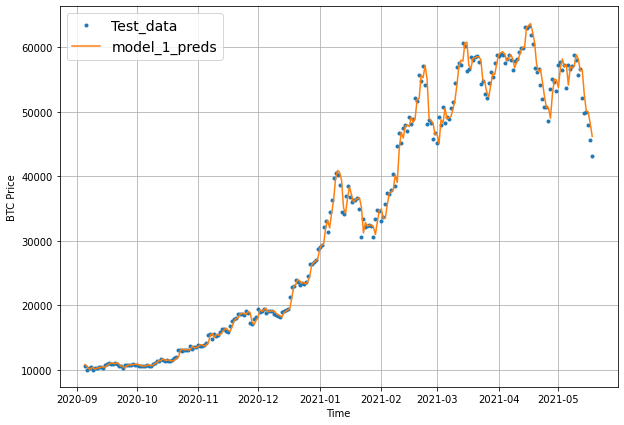

In [42]:
# Visualizing the result

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [43]:
HORIZON = 1
WINDOW_SIZE = 30

In [44]:
# Make windowed data with appropriate horizon nad window size

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [45]:
# Make train and test windows

train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows,
                                                                               labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [46]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [47]:
# Evaluate model_2 preds

model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 684.0612


684.0611572265625

In [48]:
# Load in best performing model

model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 637.2688


637.268798828125

In [49]:
# Get forecast predictions

model_2_preds = make_preds(model_2,
                           input_data=test_windows)
model_2_preds[-10:]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([56866.996, 58343.477, 58633.78 , 57051.992, 55740.81 , 53819.527,
       50965.38 , 49777.24 , 49456.805, 46078.62 ], dtype=float32)>

In [50]:
# Evaluate results for model_2 prediction

model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)

In [51]:
model_2_results

{'mae': 637.26886,
 'mse': 1365238.0,
 'rmse': 1168.434,
 'mape': 2.894602,
 'mase': 1.1139523}

### Model 3: Dense (window = 30, horizon = 7)

In [52]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [53]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [54]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name = "model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [55]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1351.0764


1351.076416015625

In [56]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1234.3971


1234.3970947265625

In [57]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[-5:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[56064.043, 57066.047, 56005.78 , 55910.73 , 55576.664, 55604.688,
        55380.973],
       [57159.98 , 56924.887, 56632.5  , 57489.3  , 56707.492, 57618.33 ,
        56786.887],
       [58946.13 , 59197.85 , 59658.258, 59394.043, 59105.086, 58999.992,
        59994.93 ],
       [57900.39 , 58920.32 , 59165.2  , 59128.57 , 59268.79 , 58074.51 ,
        59548.65 ],
       [57077.953, 57704.35 , 56942.137, 56873.332, 57890.16 , 56882.99 ,
        59083.492]], dtype=float32)>

In [58]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 598.78864 ,  430.7839  ,  337.99332 ,  329.08133 ,  228.28516 ,
         339.09018 ,  553.91907 ,  588.28204 ,  502.20584 ,  546.70105 ,
         739.18536 ,  762.2067  ,  818.3826  ,  817.2355  ,  606.1888  ,
         184.55127 ,  204.67033 ,  242.61914 ,  262.09933 ,  288.14795 ,
         156.94385 ,  176.27316 ,  358.51987 ,  358.20724 ,  205.54094 ,
         150.24986 ,  117.46471 ,  124.64007 ,  125.38197 ,  122.107   ,
         287.79373 ,  391.77475 ,  354.67252 ,  343.88818 ,  223.73347 ,
         276.52936 ,  283.0796  ,  242.04422 ,  201.54199 ,  212.13295 ,
         480.14572 ,   69.64732 ,   47.203194,   62.31822 ,   89.7011  ,
         121.62695 ,   72.128624,   78.5459  ,   97.22677 ,  104.16874 ,
          78.57875 ,  129.86531 ,  171.89494 ,  182.33328 ,  251.5339  ,
         360.80405 ,  542.1641  ,  625.1497  ,  538.33093 ,  625.6211  ,
         391.6141  ,  236.15242 ,  255.5581  ,  388.6142  ,  394.80414 ,
         532.9713  ,  492.3884  ,  584.19336

### Make our evaluation function work for larger horizon

In [59]:
def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [60]:
# Get model_3 reults

model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1234.3971,
 'mse': 5319978.5,
 'rmse': 1413.6187,
 'mape': 5.491115,
 'mase': 2.1965406}

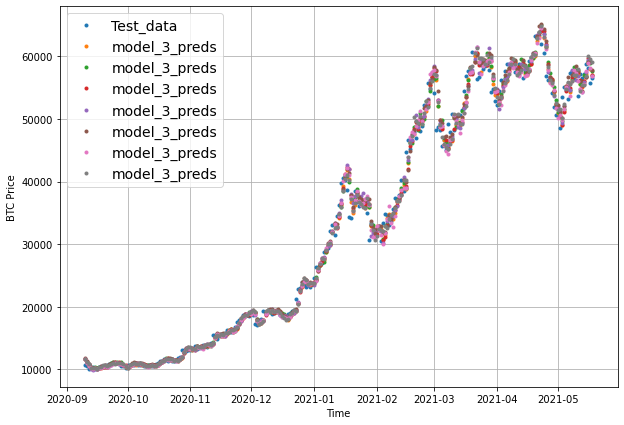

In [61]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

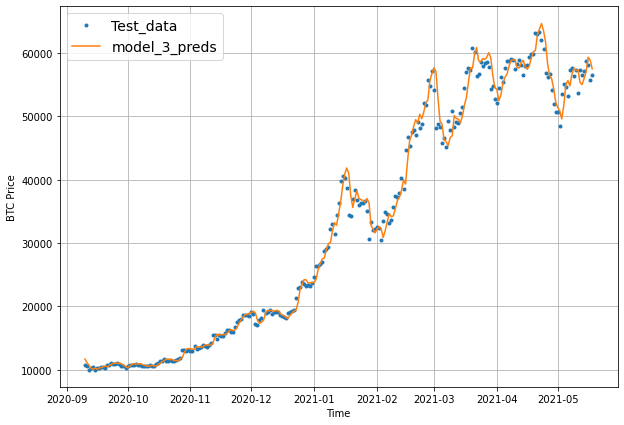

In [62]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format="-", start=offset, label="model_3_preds")

### Which of our model is performing best so far?

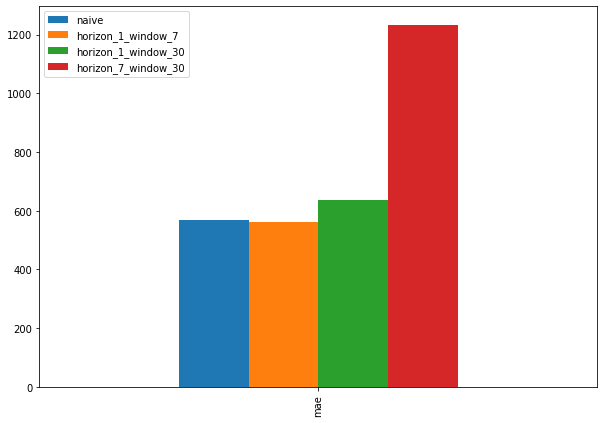

In [63]:
pd.DataFrame({"naive":naive_results["mae"],
              "horizon_1_window_7":model_1_results["mae"],
              "horizon_1_window_30":model_2_results["mae"],
              "horizon_7_window_30":model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

### Model 4: Conv1D

In [64]:
HORIZON = 1
WINDOW_SIZE = 7

In [65]:
# Create windowed dataset

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [66]:
# Create test/train splits

train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [67]:
# Check data sample shapes
train_windows[0].shape

(7,)

In [68]:
# Before we pass our data to conv1D, we have to reshape it to make sure it works

x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with Expanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with Expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [69]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_Conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [70]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [71]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 7ms/step - loss: 575.8429


575.8428955078125

In [72]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:5]

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8893.159, 8765.948, 8970.571, 8795.962, 8725.608], dtype=float32)>

In [73]:
# Evaluate predictions

model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 575.8429,
 'mse': 1198789.1,
 'rmse': 1094.8922,
 'mape': 2.5807207,
 'mase': 1.0115964}

### Model 5: RNN (LSTM)

In [74]:
tf.random.set_seed(42)

# Let's an LSTM model with the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# print(x.shape)
# x= layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# print(x.shape)
# Add another optional dense layer
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile the model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 6s 170ms/step - loss: 2114.3792 - val_loss: 6620.6338
Epoch 2/100
18/18 [==============================] - 3s 154ms/step - loss: 416.3790 - val_loss: 1601.1873
Epoch 3/100
18/18 [==============================] - 3s 186ms/step - loss: 207.3454 - val_loss: 1031.4054
Epoch 4/100
18/18 [==============================] - 5s 279ms/step - loss: 184.6049 - val_loss: 1024.7379
Epoch 5/100
18/18 [==============================] - 6s 369ms/step - loss: 177.4096 - val_loss: 1008.5728
Epoch 6/100
18/18 [==============================] - 5s 300ms/step - loss: 178.6419 - val_loss: 980.9445
Epoch 7/100
18/18 [==============================] - 5s 312ms/step - loss: 177.7172 - val_loss: 973.3240
Epoch 8/100
18/18 [==============================] - 4s 207ms/step - loss: 171.8551 - val_loss: 961.2667
Epoch 9/100
18/18 [==============================] - 0s 21ms/step - loss: 170.4987 - val_loss: 967.4836
Epoch 10/100
18/18 [==============================

In [75]:
# Load in the best version of model 5 and evaluate

model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 582.5177


582.5177001953125

In [76]:
# Make prediction with our LSTM model

model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8960.968, 8829.702, 9007.382, 8822.339, 8780.258, 8771.303,
       8728.688, 8556.558, 8510.977, 8539.89 ], dtype=float32)>

In [77]:
# Evaluate model 5 preds

model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 582.51764,
 'mse': 1223780.5,
 'rmse': 1106.2461,
 'mape': 2.6210868,
 'mase': 1.0233221}

### Make a multivariate time series

In [78]:
# Lets make a multivariate time series

bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [79]:
# Block reward values

block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

# Block reward dates

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [80]:
# Get datetime indexes for when to add in different block dates

block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [81]:
# Add block reward column

bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block reward column

bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days: block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


<AxesSubplot:xlabel='Date'>

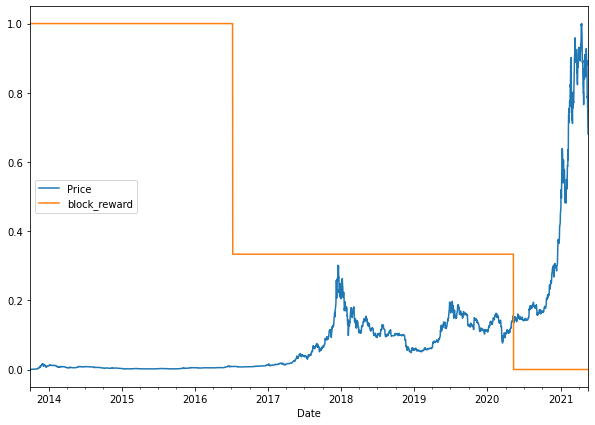

In [82]:
# Plot the block reward/price over time

from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

### Making a windowed dataset with pandas

In [83]:
# Setup dataset hyperparameters

HORIZON = 1
WINDOW_SIZE = 7

In [84]:
# Make a copy of the bitcoin historical data with block reward feature

bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [85]:
# Lets create X & y, remove the Nans and convert to float32 to prevent TensorFlow errors

X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [86]:
# View labels

y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [87]:
# Make train and tests

split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

### Model 6: Dense (multivariate time series)

In [88]:
# Make multivariate time series model

tf.random.set_seed(42)
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    # Layers.Dense(128, activation="relu"), # Adding an extra layer here should lead to beating the native model
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [89]:
# Make sure best model is loaded and evaluate

model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 5ms/step - loss: 562.9236


562.9236450195312

In [90]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8854.238, 8794.461, 9023.399, 8762.944, 8773.223, 8728.964,
       8682.168, 8527.269, 8466.59 , 8527.025], dtype=float32)>

In [91]:
# Evaluate preds

model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 562.92365,
 'mse': 1150147.8,
 'rmse': 1072.4493,
 'mape': 2.5229714,
 'mase': 0.9889009}

In [92]:
model_1_results

{'mae': 562.63727,
 'mse': 1155255.9,
 'rmse': 1074.8282,
 'mape': 2.5150347,
 'mase': 0.98839784}

### Model 7: N-BEATS algorithm

In [93]:
# Create NBeatsBlock custom layer

class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs takes crae of all the parameters for the parent class
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is theta layerwith linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon]

    return backcast, forecast

In [94]:
# Setup dummy NBeatsBlock layer to represent inouts and outputs

dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [95]:
# Create dummy inputs (have to be same size as input size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [96]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.41354012 -0.16135904 -0.38314706  0.45759946 -0.7261176   0.21731108
  0.4846486 ]
Forecast: 0.18513312935829163


### Preparing data for N-BEATS algorithm using tf.data

In [97]:
HORIZON = 1 # how far to predict
WINDOW_SIZE = 7 # how far to lookback

In [98]:
# Create NBEATS data inputs
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [99]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Prices+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [100]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']

# Make train and test sets
split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [101]:
# 1. Turn train and test sets into tensor datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features and labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

In [102]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D

N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

In [103]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, Compiling and Fitting the N-BEATS algorithm

In [104]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link
residuals = layers.subtract([stack_input, backcast], name="subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)):

  # 5. Use the NBeatsBlock to calculate the backcast and forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile the model
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 303: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 403: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 3min 10s, sys: 3.08 s, total: 3min 13s
Wall time: 4min 9s


In [105]:
# Evaluate N-BEATS model on test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 38ms/step - loss: 579.4615 - mae: 579.4615 - mse: 1147939.2500


[579.4614868164062, 579.4614868164062, 1147939.25]

In [106]:
# Make predictions with N-Beats model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8946.303, 8828.089, 9076.44 , 8845.293, 8822.618, 8844.119,
       8730.333, 8581.522, 8559.392, 8578.117], dtype=float32)>

In [107]:
# Evaluate N-BEATS model prediction
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 579.4615,
 'mse': 1147939.2,
 'rmse': 1071.4192,
 'mape': 2.724918,
 'mase': 1.0179533}

### Plotting N-BEATS architecture we have created

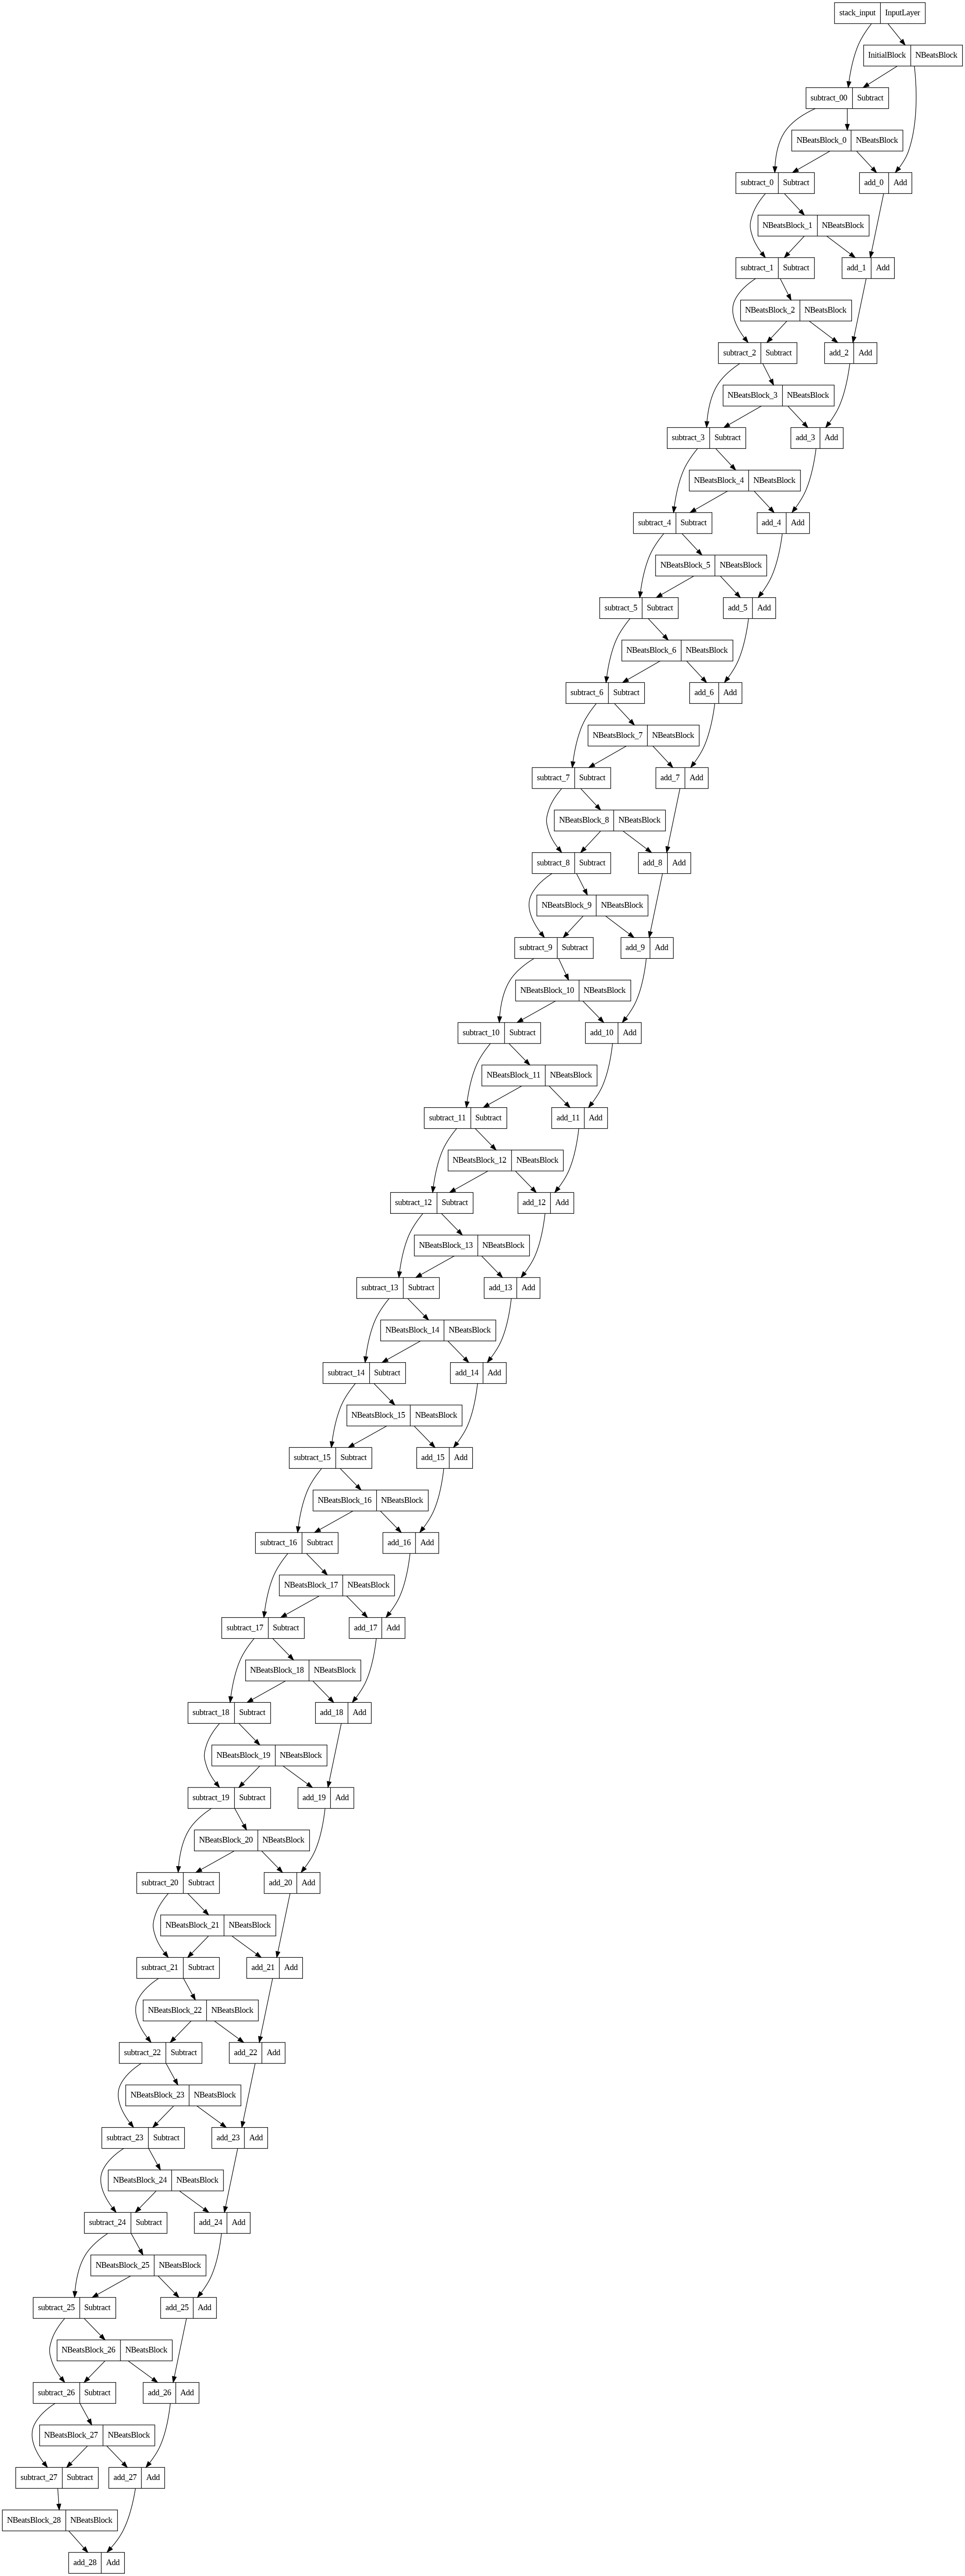

In [108]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [109]:
model_7.save(model_7.name)

### Model 8: Creating an ensemble (stacking different models together)

In [110]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=['mae', 'mse', 'mape']):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For eg. if num_iter=10, Total number of models returned=30
  """

  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['mae', 'mse'])
      
      # Fit the model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append the fitted to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [111]:
%%time

# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 117: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 391: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 491: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 797: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 897: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 997: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 187: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 499: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 599: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 699: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07

### Make predictions with an ensemble model

In [112]:
# Create a function which uses a list of trained models to make and return a list of prediction

def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  
  return tf.constant(tf.squeeze(ensemble_preds))

In [113]:
# Create a list of ensemble predictions

ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 95ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8779.818,  8814.44 ,  9060.444, ..., 50685.89 , 48254.645,
        47003.176],
       [ 8757.833,  8748.496,  9044.282, ..., 49808.746, 48109.523,
        45030.79 ],
       [ 8812.092,  8785.906,  9042.978, ..., 49787.2  , 48552.676,
        47015.74 ],
       ...,
       [ 8779.664,  8806.773,  9072.697, ..., 50313.17 , 48747.062,
        46525.35 ],
       [ 8731.991,  8703.485,  9036.752, ..., 49894.844, 48420.33 ,
        46196.5  ],
       [ 8798.798,  8810.744,  9090.717, ..., 50522.41 , 48386.277,
        45917.477]], dtype=float32)>

In [114]:
# Evaluate ensemble model(s) predictions

ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))
ensemble_results

{'mae': 568.2582,
 'mse': 1146149.2,
 'rmse': 1070.5836,
 'mape': 2.582691,
 'mase': 0.99827224}